# EDA


## DESCRIPCIÓN DEL PROYECTO

 En Los Ángeles existe un sistema compartido de bicicletas que brinda datos anónimos acerca
 del uso del servicio. La tabla que se proporciona contiene el histórico de viajes que se han
 realizado desde 2016 y contiene una columna que es de particular interés y que se buscará
 analizar a más profundidad: Passholder_type.  A continuación se presentan las columnas
 que contiene la tabla:

- ``trip_id``: identificador único para el viaje
- ``duration``: duración del viaje en minutos
- ``start_time``: dia/hora donde en viaje inicia en formato ISO 8601 tiempo local
- ``end_time``: dia/hora donde el viaje termina en formato ISO 8601 tiempo local
- ``start_station``: la estación donde el viaje inició
- ``start_lat``: la latitud de la estación donde el viaje se originó
- ``start_lon``: la longitud de la estación donde el viaje se originó
- ``end_station``: la estación donde el viaje terminó
- ``end_lat``: la latitud de la estación donde terminó el viaje
- ``end_lon``: la longitud de la estación donde terminó el viaje
- ``bike_id``: un entero único que identifica la bicicleta
- ``plan_duration``: número de días que el usuario tendrá el plan. 0 significa un viaje único (Walk-up plan)
- ``trip_route_category``: “Round trip” son viajes que empiezan y terminan en la misma estación
- ``passholder_type``: El nombre del plan de passholder


## Limpieza de datos y EDA

In [5]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import folium
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import display
import os
from pathlib import Path
import re
from sklearn.cluster import KMeans



# Configuración de gráficos
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

# Ignorar warnings
warnings.filterwarnings('ignore')



# Cargar librerias
def find_file(filename, search_dir=None):
    """
    Busca un archivo en la jerarquía de carpetas hacia arriba hasta encontrarlo.
    Si search_dir no se especifica, comienza desde el directorio actual.
    """
    search_dir = Path(search_dir) if search_dir else Path.cwd()
    
    # Buscar en la carpeta actual y subir niveles hasta encontrar el archivo
    for parent in search_dir.parents:
        possible_path = parent / filename
        if possible_path.exists():
            return possible_path

    raise FileNotFoundError(f'No se encontró el archivo {filename} en la estructura de directorios.')

# Buscar el archivo en la jerarquía
data_path = find_file('data/train_set.csv')

# Cargar el dataset con la ruta encontrada
df = pd.read_csv(data_path)

print(f'Dataset cargado correctamente desde: {data_path}')

# Función para mostrar información general del dataset
def summarize_data(df):
    """Muestra información general del DataFrame."""
    print("Primeras filas del dataset:")
    display(df.head(5))

    print("\n Información general del dataset:")
    df.info()

    print("\n Estadísticas descriptivas:")
    display(df.describe(include="all"))  

    print("\n Columnas en el dataset:")
    print(df.columns.to_list())

    print("\n Dimensiones del dataset (filas, columnas):", df.shape)

    print("\n Valores nulos por columna:")
    display(df.isnull().sum())

    print("\n Tipos de datos:")
    display(df.dtypes)

    print("\n Valores únicos en 'passholder_type':")
    display(df['passholder_type'].unique())

    print("\n Valores únicos en 'plan_duration':")
    display(df['plan_duration'].unique())

    print("\n Valores únicos en 'duration':")
    display(df['duration'].unique())

    print("\n Valores únicos en 'trip_route_category':")
    display(df['trip_route_category'].unique())

    print("\n Duplicados en el dataset:", df.duplicated().sum())

# Ejecutar funciones de análisis
summarize_data(df)


Dataset cargado correctamente desde: c:\Users\candy\Downloads\arkon_ds\data\train_set.csv
Primeras filas del dataset:


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443



 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
count,7.000000e+05,700000.000000,700000,700000,694437.000000,694437.000000,681426.000000,681426.000000,700000,699792.000000,700000,697424,700000.000000,700000.000000
unique,NaN,NaN,567695,547772,NaN,NaN,NaN,NaN,7563,NaN,2,6,NaN,NaN
top,NaN,NaN,2018-10-03 09:29:00,2018-07-17 17:08:00,NaN,NaN,NaN,NaN,19544,NaN,One Way,Monthly Pass,NaN,NaN
freq,NaN,NaN,12,12,NaN,NaN,NaN,NaN,1183,NaN,582076,394769,NaN,NaN
mean,1.069468e+08,37.084979,NaN,NaN,34.044952,-118.253849,34.044175,-118.259183,NaN,44.928697,NaN,NaN,3499.720464,3489.726771
std,4.497342e+07,125.302510,NaN,NaN,0.325255,2.332640,0.299721,2.129781,NaN,92.816296,NaN,NaN,615.918795,613.040769
min,8.369648e+06,1.000000,NaN,NaN,33.710979,-118.495422,33.710979,-118.495422,NaN,0.000000,NaN,NaN,3000.000000,3000.000000
25%,7.538051e+07,7.000000,NaN,NaN,34.037460,-118.280952,34.037048,-118.280952,NaN,1.000000,NaN,NaN,3031.000000,3030.000000
50%,1.179410e+08,13.000000,NaN,NaN,34.046612,-118.256980,34.046520,-118.256981,NaN,30.000000,NaN,NaN,3064.000000,3064.000000
75%,1.404178e+08,26.000000,NaN,NaN,34.051941,-118.247162,34.050911,-118.246422,NaN,30.000000,NaN,NaN,4214.000000,4214.000000



 Columnas en el dataset:
['trip_id', 'duration', 'start_time', 'end_time', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type', 'start_station', 'end_station']

 Dimensiones del dataset (filas, columnas): (700000, 14)

 Valores nulos por columna:


trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               5563
start_lon               5563
end_lat                18574
end_lon                18574
bike_id                    0
plan_duration            208
trip_route_category        0
passholder_type         2576
start_station              0
end_station                0
dtype: int64


 Tipos de datos:


trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_lat              float64
start_lon              float64
end_lat                float64
end_lon                float64
bike_id                 object
plan_duration          float64
trip_route_category     object
passholder_type         object
start_station            int64
end_station              int64
dtype: object


 Valores únicos en 'passholder_type':


array(['Walk-up', 'Monthly Pass', 'One Day Pass', 'Annual Pass',
       'Flex Pass', nan, 'Testing'], dtype=object)


 Valores únicos en 'plan_duration':


array([  1.,   0.,  30., 365.,  nan, 999., 150.])


 Valores únicos en 'duration':


array([  35,   32,    6, ..., 1284, 1040,  965], dtype=int64)


 Valores únicos en 'trip_route_category':


array(['Round Trip', 'One Way'], dtype=object)


 Duplicados en el dataset: 0


### **Análisis de las Salidas del EDA**
---
Las columnas estan en formato `snake_case`, evitandome el trabajo de esa buena práctica.
1. **No hay valores duplicados** 
2. **Las categorías de `passholder_type` y `trip_route_category` parecen consistentes** (excepto por un valor "Testing").
3. **Número de registros y columnas bien definidos** (`700,000 filas x 14 columnas`).

---

### **Problemas Detectados:**

- **1 Tipos de datos incorrectos**
`passholder_type` y `trip_route_category` son `object` por lo que los convertiré a categorías para gráficar y el problema de predicción es de tipo categórico.

`trip_route_category` tiene dos valores 'Round Trip' y 'One Way', el cual indica si se regreso a la misma base y si fue a otra base de bicicletas, respectivamente.

`start_time` y `end_time` son `object`, pero deberían ser **`datetime`**.  Además estan en formato ISO el cual desconozco del todo si funciona en pyton, por lo que lo transformaré a un formato más general y posteriormente a datetime.

`bike_id`, `trip_id`, `start_station`, `end_station` los convertire por mientras a tipo de dato categórico para más adelante poder gráficar.  

`plan_duration` lo pasare a entero porque tiene un error de tipeo con un punto y el tipo de datos es flotante, e indica el número de días que se estuvo en el plan, además sí es 0, significa que fue un viaje único o `Walk-up plan`

`duration` es en formato entero, por lo que ya esta correcta, solo es importante indicar que es la duración del viaje en minuto.

---

- **2️ Datos faltantes o nulos (`NaN`)**
**Variables con valores nulos importantes**:
- `start_lat` y `start_lon`: **5,563 valores nulos**.
- `end_lat` y `end_lon`: **18,574 valores nulos**.
- `plan_duration`: **208 valores nulos**.
- `passholder_type`: **2,576 valores nulos**.

**Posibles soluciones**:
- Para las coordenadas (`start_lat`, `start_lon`, `end_lat`, `end_lon`):
  - Opciones:
    1. **Eliminar registros con demasiados nulos**.
    2. **Imputar con la media/mediana de la estación más cercana**.
    3. **Rellenar con valores de estaciones similares**.

- Para `plan_duration`:
  - Imputar con **0** si `trip_route_category == "One Way"`.

- Para `passholder_type`:
  - Si hay patrones, se puede **predecir con un modelo**.
  - De lo contrario, **eliminar registros con `NaN`**.
  - Será necesario elminar las columnas con `test` porque en el analisis posterior se encontro que en los datos de prueba no estan y sesgan los modelos. Lo cual se hara el featuring engenering.

  **Dejo indicada las posibles soluciones pero aunque me ecnataría revisar a fondo las posibles causas de lo valores nulos y tratarlos por separado, debido a la falta de tiempo de entrega del proyecto, eliminaré todos los valores nulos, ya que el número más grande que existe de valores nulos es de `18574`, lo cual representa solo el `2%` de todo el dataset, y tratar de lidiar con esa pequeña cantidad de valores podría sesgar el analisis futuro. Por lo que eliminaré esos datos a la hora del trataiento.**

---

- **3 Rango de valores extraños**
**Duración de los viajes (`duration`)**:
- Mínimo: 1 minuto.
- Máximo: 1,440 minutos (24 horas) (Posibles errores de registro).
- Será necesario hacer una analisis de valores átipicos.

**Coordenadas (`start_lat`, `start_lon`, `end_lat`, `end_lon`)**:
- Rango esperado: **Los Ángeles (~33.7° a 34.3° latitud)**.
- **Valores fuera de este rango podrían ser errores**:
  - Ejemplo: `55.7° latitud` - Esto está en **Rusia**.
  Por lo tanto eliminare `coordenadas que no se salen de la ciudad de Los Angeles.

---


## Solución

In [ ]:


def normalize_date_format(date_str):
    """
    Función para convertir fechas de diferentes formatos a un estándar YYYY-MM-DD HH:MM:SS.
    """
    if pd.isna(date_str):  # Si es NaN, lo dejamos igual
        return np.nan

    # Si ya está en formato ISO 8601 (YYYY-MM-DD HH:MM:SS), lo dejamos igual
    if re.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', date_str):
        return date_str

    # Si el formato es M/D/YYYY H:MM (sin segundos), convertimos a YYYY-MM-DD HH:MM:SS
    if re.match(r'\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}', date_str):
        return pd.to_datetime(date_str, format='%m/%d/%Y %H:%M').strftime('%Y-%m-%d %H:%M:%S')

    # Si el formato es M/D/YYYY (sin hora), agregamos una hora por defecto
    if re.match(r'\d{1,2}/\d{1,2}/\d{4}', date_str):
        return pd.to_datetime(date_str, format='%m/%d/%Y').strftime('%Y-%m-%d 00:00:00')

    return np.nan  # Si no cumple ningún formato, lo convertimos a NaN

# Crear una copia del DataFrame original para no modificarlo
df_clean = df.copy()

# Aplicamos la normalización a las columnas de fecha
df_clean['start_time'] = df_clean['start_time'].astype(str).apply(normalize_date_format)
df_clean['end_time'] = df_clean['end_time'].astype(str).apply(normalize_date_format)

# Convertimos las fechas ya estandarizadas a datetime64
df_clean['start_time'] = pd.to_datetime(df_clean['start_time'], errors='coerce')
df_clean['end_time'] = pd.to_datetime(df_clean['end_time'], errors='coerce')

# Corrección de plan_duration (convertir a int)
df_clean['plan_duration'] = df_clean['plan_duration'].fillna(0).astype(int)

# Conversión a datos categóricos
df_clean['passholder_type'] = df_clean['passholder_type'].astype('category')
df_clean['trip_route_category'] = df_clean['trip_route_category'].astype('category')
df_clean['bike_id'] = df_clean['bike_id'].astype('category')
df_clean['start_station'] = df_clean['start_station'].astype('category')
df_clean['end_station'] = df_clean['end_station'].astype('category')

# Eliminación de valores nulos (AHORA sí, sin sobrescribir los cambios)
df_clean.dropna(inplace=True)

print('Dataset limpio')
summarize_data(df_clean)


In [7]:
summarize_data(df_clean)


Primeras filas del dataset:


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1,Round Trip,Walk-up,4127,4127
1,46560345,32,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30,One Way,Monthly Pass,3022,3062
3,129547190,138,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,1,One Way,One Day Pass,4304,4311
4,136619463,14,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,30,One Way,Monthly Pass,4266,4443



 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 675787 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_id              675787 non-null  int64         
 1   duration             675787 non-null  int64         
 2   start_time           675787 non-null  datetime64[ns]
 3   end_time             675787 non-null  datetime64[ns]
 4   start_lat            675787 non-null  float64       
 5   start_lon            675787 non-null  float64       
 6   end_lat              675787 non-null  float64       
 7   end_lon              675787 non-null  float64       
 8   bike_id              675787 non-null  category      
 9   plan_duration        675787 non-null  int32         
 10  trip_route_category  675787 non-null  category      
 11  passholder_type      675787 non-null  category      
 12  start_station        675787 non-null  cate

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
count,6.757870e+05,675787.000000,675787,675787,675787.000000,675787.000000,675787.000000,675787.000000,675787,675787.000000,675787,675787,675787.0,675787.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7512,NaN,2,6,362.0,366.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19544,NaN,One Way,Monthly Pass,3005.0,3005.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1160,NaN,560179,387596,27918.0,30443.0
mean,1.063264e+08,31.092674,2019-04-02 14:31:06.672422656,2019-04-02 15:03:42.702633728,34.044957,-118.253717,34.043957,-118.260346,NaN,44.814030,NaN,NaN,NaN,NaN
min,8.369648e+06,1.000000,2016-10-01 00:48:00,2016-10-01 00:52:00,33.710979,-118.495422,33.710979,-118.495422,NaN,0.000000,NaN,NaN,NaN,NaN
25%,7.403668e+07,7.000000,2018-02-24 13:42:00,2018-02-24 14:21:30,34.038609,-118.280182,34.037460,-118.280510,NaN,1.000000,NaN,NaN,NaN,NaN
50%,1.167904e+08,13.000000,2019-03-05 15:56:00,2019-03-05 16:10:00,34.046612,-118.256668,34.046520,-118.256980,NaN,30.000000,NaN,NaN,NaN,NaN
75%,1.397129e+08,25.000000,2020-03-21 12:32:00,2020-03-21 13:18:30,34.051941,-118.246422,34.050911,-118.246422,NaN,30.000000,NaN,NaN,NaN,NaN
max,1.794576e+08,1440.000000,2021-12-31 22:57:00,2022-01-01 21:35:00,55.705528,118.238258,55.705528,37.606541,NaN,999.000000,NaN,NaN,NaN,NaN



 Columnas en el dataset:
['trip_id', 'duration', 'start_time', 'end_time', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type', 'start_station', 'end_station']

 Dimensiones del dataset (filas, columnas): (675787, 14)

 Valores nulos por columna:


trip_id                0
duration               0
start_time             0
end_time               0
start_lat              0
start_lon              0
end_lat                0
end_lon                0
bike_id                0
plan_duration          0
trip_route_category    0
passholder_type        0
start_station          0
end_station            0
dtype: int64


 Tipos de datos:


trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_lat                     float64
start_lon                     float64
end_lat                       float64
end_lon                       float64
bike_id                      category
plan_duration                   int32
trip_route_category          category
passholder_type              category
start_station                category
end_station                  category
dtype: object


 Valores únicos en 'passholder_type':


['Walk-up', 'Monthly Pass', 'One Day Pass', 'Annual Pass', 'Flex Pass', 'Testing']
Categories (6, object): ['Annual Pass', 'Flex Pass', 'Monthly Pass', 'One Day Pass', 'Testing', 'Walk-up']


 Valores únicos en 'plan_duration':


array([  1,   0,  30, 365, 150, 999])


 Valores únicos en 'duration':


array([  35,   32,    6, ..., 1352,  741, 1436], dtype=int64)


 Valores únicos en 'trip_route_category':


['Round Trip', 'One Way']
Categories (2, object): ['One Way', 'Round Trip']


 Duplicados en el dataset: 0


## Valores Átipicos


📌 duration: 73188 valores atípicos detectados


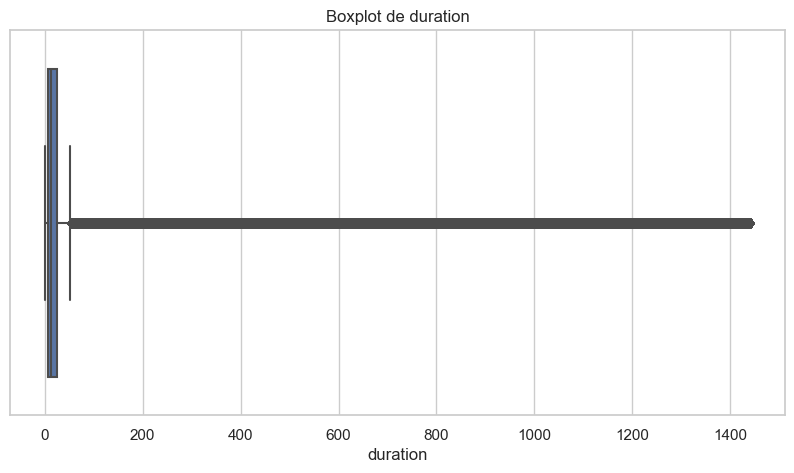


📌 plan_duration: 50527 valores atípicos detectados


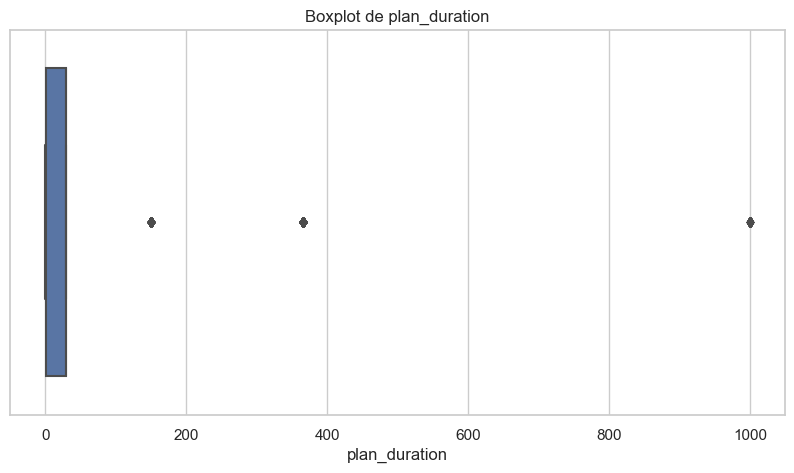

In [6]:
def detect_outliers(df, columns=None):
    '''Detecta valores atípicos en un DataFrame usando el método IQR y genera boxplots.'''
    
    if columns is None:
        # Excluir columnas categóricas y de fechas automáticamente
        columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    outliers_dict = {}

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_dict[col] = len(outliers)

        print(f'\n📌 {col}: {len(outliers)} valores atípicos detectados')

        # Generar boxplot
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.show()

    return outliers_dict

# Columnas numéricas a evaluar
outlier_columns = ['duration', 'plan_duration']
outliers_found = detect_outliers(df_clean, columns=outlier_columns)



### **Análisis de Valores Atípicos**
#### ** `duration` (Duración del viaje)**
- **Total de registros**: `675,787`
- **Valores atípicos detectados**: `73,188` (~10.83% del dataset)
- **Rango de valores**:
  - **Mínimo:** `1` minuto
  - **Percentil 25%:** `7` minutos
  - **Mediana (50%):** `13` minutos
  - **Percentil 75%:** `25` minutos
  - **Máximo:** `1,440` minutos (`24 horas`)

    **Conclusión:**  
- La mayoría de los viajes duran entre `7 y 25 minutos`, pero hay viajes extremadamente largos mayores a  120 minutos, lo cual es inusual para un sistema de bicicletas compartidas. Pero eso no significa que no sea posible, salvo datos a mi consideración que pasen las 6 horas, pero al ser pocos, de momento los dejaré para mejorar la flexibilidad de respuesta del modelo cuando le lleguen datos átipicos, si hubiera una cantida mayor procedería a analizar el numero de viajes que superan las 6 horas.

---

#### **`plan_duration` (Duración del plan del usuario)**
- **Valores atípicos detectados**: `50,527` (~7.48% del dataset)
- **Rango de valores**:
  - **Mínimo:** `0` días (`Walk-up plan`)
  - **Percentil 25%:** `1` día
  - **Mediana (50%):** `30` días (`Plan mensual`)
  - **Percentil 75%:** `30` días
  - **Máximo:** `999` días

    **Conclusión:**  
- Se observa que la mayoría de los planes son de 1 o 30 días.
- Valores como `999 días` y `150 días` parecen errores o valores fuera de estándar, pero no es así ya que el df tiene datos de más de 2 años, que más adelante mapeare una serie de tiempo con todos los planes para ver la duración que tienen. Por ello tampoco eliminaré ningún registro nulo, lo ideal es borrar la menos cantidad de información a menos que parezca absurda, para el contexto del negocio todo va a acorde.
- Podrían haber planes anuales (`365 días`) y las cantidades que los superen podría indicar que hay usuarios que llevan mas de un año con el servicio.




## Tratamiento  para Coordenadas Geográficas

Dado que los viajes son en Los Ángeles, podemos establecer un rango esperado de coordenadas basado en los límites geográficos de la ciudad con una atitud esperada:
- Mínimo: 33.7° (sur de Los Ángeles)
- Máximo: 34.3° (norte de Los Ángeles)

Y una longitud esperada:
- Mínimo: -118.5° (oeste, cerca del océano)
- Máximo: -118.15° (este, dentro de la ciudad)

In [8]:
def count_geolocation_outliers(df):
    '''Cuenta registros con coordenadas fuera del área esperada de Los Ángeles.'''
    
    # Rango válido de Los Ángeles
    lat_min, lat_max = 33.7, 34.3
    lon_min, lon_max = -118.5, -118.15
    
    # Filtrar registros fuera del rango
    mask = ~(
        (df['start_lat'].between(lat_min, lat_max)) & 
        (df['start_lon'].between(lon_min, lon_max)) & 
        (df['end_lat'].between(lat_min, lat_max)) & 
        (df['end_lon'].between(lon_min, lon_max))
    )

    outliers_count = mask.sum()
    print(f'Registros fuera del área de Los Ángeles: {outliers_count}')
    return outliers_count

# Llamar a la función para ver cuántos registros son atípicos
count_geolocation_outliers(df_clean)



Registros fuera del área de Los Ángeles: 23272


23272

Existen `23272` registros erroneos, los cuales podrían coincidir con algunos valores átipicos previamente estudiados, estos sí será imputados en la siguiente función.

In [9]:
def remove_geolocation_outliers(df):
    '''Elimina registros con coordenadas fuera del área esperada de Los Ángeles.'''
    
    # Rango válido de Los Ángeles
    lat_min, lat_max = 33.7, 34.3
    lon_min, lon_max = -118.5, -118.15
    
    # Filtrar registros dentro del rango
    mask = (
        (df['start_lat'].between(lat_min, lat_max)) & 
        (df['start_lon'].between(lon_min, lon_max)) & 
        (df['end_lat'].between(lat_min, lat_max)) & 
        (df['end_lon'].between(lon_min, lon_max))
    )

    df_filtered = df[mask].copy()
    print(f'Registros eliminados por estar fuera de Los Ángeles: {len(df) - len(df_filtered)}')
    return df_filtered

df_clean = remove_geolocation_outliers(df_clean)


Registros eliminados por estar fuera de Los Ángeles: 23272


## Gráficos

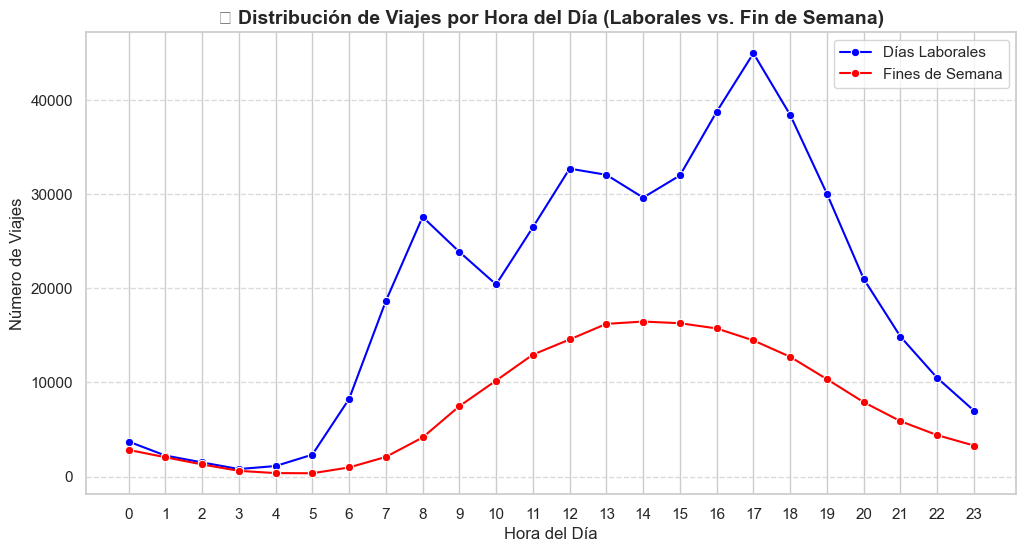

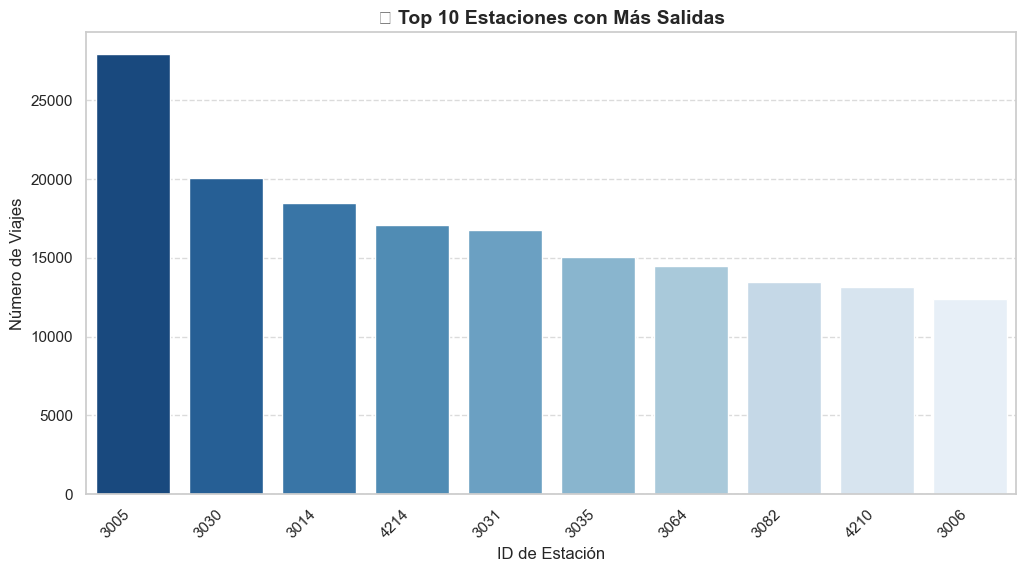

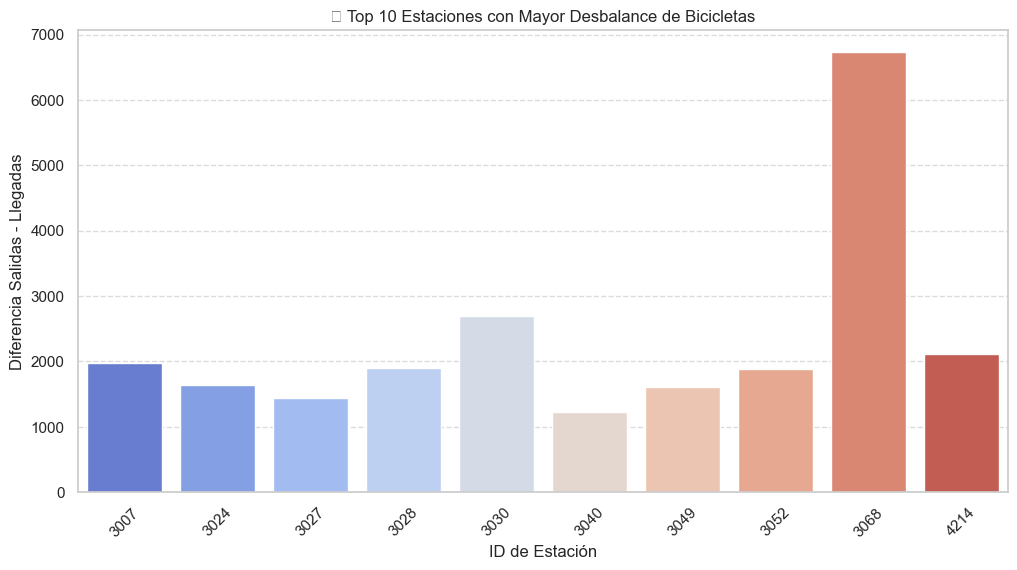

🗺️ Mapa de calor generado.


🗺️ Mapa de rutas generado.


Mapa de clusters generado.


Mapa de estaciones con mayor desbalance generado.


Mapa de estaciones con más viajes generado.


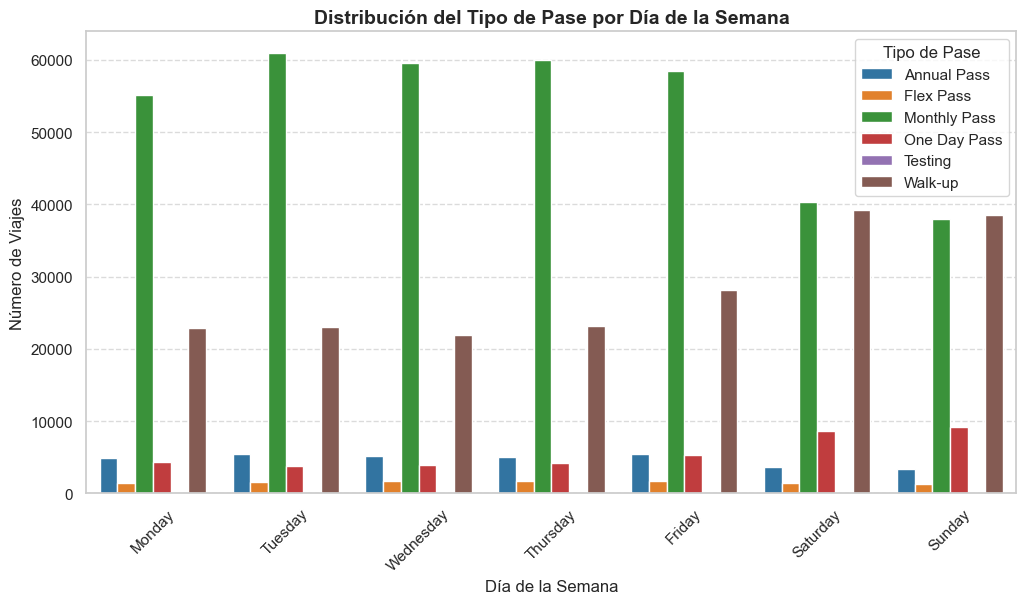

In [ ]:
### 1 Análisis de Saturación del Servicio
def viajes_por_hora(df):
    '''Gráfico de distribución de viajes por hora del día diferenciando días laborales vs. fines de semana.'''
    
    # Extraer la hora y el día de la semana
    df["hour"] = df["start_time"].dt.hour
    df["day_of_week"] = df["start_time"].dt.day_name()

    # Separar datos en días laborales y fines de semana
    weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    weekends = ["Saturday", "Sunday"]
    
    df_weekdays = df[df["day_of_week"].isin(weekdays)]
    df_weekends = df[df["day_of_week"].isin(weekends)]
    
    # Contar viajes por hora
    weekday_counts = df_weekdays["hour"].value_counts().sort_index()
    weekend_counts = df_weekends["hour"].value_counts().sort_index()

    # Crear gráfico
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=weekday_counts.index, y=weekday_counts.values, label="Días Laborales", color="blue", marker="o")
    sns.lineplot(x=weekend_counts.index, y=weekend_counts.values, label="Fines de Semana", color="red", marker="o")

    # Ajustes de visualización
    plt.xlabel("Hora del Día", fontsize=12)
    plt.ylabel("Número de Viajes", fontsize=12)
    plt.title(" Distribución de Viajes por Hora del Día (Laborales vs. Fin de Semana)", fontsize=14, fontweight="bold")
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


### 2 Análisis de Estaciones Más Usadas
def estaciones_mas_usadas(df, top_n=10):
    '''Identificar las estaciones más utilizadas para optimizar disponibilidad de bicicletas.'''
    
    # Contar el número de viajes que inician en cada estación
    start_counts = df["start_station"].value_counts().reset_index()
    start_counts.columns = ["station_id", "trip_count"]

    # Filtrar solo las estaciones con más viajes
    top_stations = start_counts.head(top_n)

    # Convertir ID de estación a string para mejorar la legibilidad
    top_stations["station_id"] = top_stations["station_id"].astype(str)

    # Crear gráfico de barras
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_stations, 
                x="station_id", 
                y="trip_count", 
                palette="Blues_r")

    # Ajustar visualización
    plt.title(f"📍 Top {top_n} Estaciones con Más Salidas", fontsize=14, fontweight="bold")
    plt.xlabel("ID de Estación", fontsize=12)
    plt.ylabel("Número de Viajes", fontsize=12)
    plt.xticks(rotation=45, ha="right")  # Rotar etiquetas para mayor claridad
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()


### 3️ Análisis de Desbalance de Estaciones
def desbalance_estaciones(df):
    '''Analizar estaciones con mayor desbalance de bicicletas (más salidas que llegadas).'''
    
    start_counts = df["start_station"].value_counts().reset_index()
    start_counts.columns = ["station_id", "trip_count_start"]

    end_counts = df["end_station"].value_counts().reset_index()
    end_counts.columns = ["station_id", "trip_count_end"]

    station_usage = pd.merge(start_counts, end_counts, on="station_id", how="outer").fillna(0)
    station_usage["trip_imbalance"] = station_usage["trip_count_start"] - station_usage["trip_count_end"]

    plt.figure(figsize=(12, 6))
    sns.barplot(data=station_usage.nlargest(10, "trip_imbalance"), 
                x="station_id", 
                y="trip_imbalance", 
                palette="coolwarm")

    plt.title("🔄 Top 10 Estaciones con Mayor Desbalance de Bicicletas")
    plt.xlabel("ID de Estación")
    plt.ylabel("Diferencia Salidas - Llegadas")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


### 4️ Análisis Geoespacial
def mapa_calor_estaciones(df):
    '''Generar un mapa de calor de estaciones más utilizadas.'''
    station_usage = df.groupby(["start_lat", "start_lon"]).size().reset_index(name="count")
    map_center = [station_usage["start_lat"].mean(), station_usage["start_lon"].mean()]
    
    mapa = folium.Map(location=map_center, zoom_start=12)
    heat_data = list(zip(station_usage["start_lat"], station_usage["start_lon"], station_usage["count"]))
    
    HeatMap(heat_data, radius=12, blur=10, min_opacity=0.4).add_to(mapa)

    display(mapa)
    print("🗺️ Mapa de calor generado.")


def mapa_rutas_frecuentes(df):
    '''Mapa de rutas más utilizadas.'''
    top_routes = df.groupby(["start_lat", "start_lon", "end_lat", "end_lon"]).size().reset_index(name="count")
    top_routes = top_routes.sort_values("count", ascending=False).head(300)  # Selecciona las 300 rutas más usadas
    
    map_center = [df["start_lat"].mean(), df["start_lon"].mean()]
    mapa = folium.Map(location=map_center, zoom_start=12)

    for _, row in top_routes.iterrows():
        folium.PolyLine([(row["start_lat"], row["start_lon"]), (row["end_lat"], row["end_lon"])],
                        color="blue", weight=2.5, opacity=0.6).add_to(mapa)

    display(mapa)
    print("🗺️ Mapa de rutas generado.")


def mapa_clusters_estaciones(df, num_clusters=5):
    '''Generar un mapa de clustering de estaciones con K-Means.'''
    station_usage = df.groupby(["start_lat", "start_lon"]).size().reset_index(name="count")
    
    # Obtener coordenadas
    coords = station_usage[["start_lat", "start_lon"]].values

    # Aplicar K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    station_usage["cluster"] = kmeans.fit_predict(coords)

    # Crear mapa
    map_center = [station_usage["start_lat"].mean(), station_usage["start_lon"].mean()]
    mapa = folium.Map(location=map_center, zoom_start=12)

    # Colores para los clusters
    colors = ["red", "blue", "green", "purple", "orange"]

    # Agregar estaciones al mapa con color según el cluster
    for _, row in station_usage.iterrows():
        cluster_index = int(row["cluster"])
        folium.CircleMarker(
            location=[row["start_lat"], row["start_lon"]],
            radius=5 + (row["count"] / station_usage["count"].max()) * 5,
            color=colors[cluster_index % len(colors)],
            fill=True,
            fill_color=colors[cluster_index % len(colors)],
            fill_opacity=0.7,
            popup=f"Cluster: {row['cluster']}, Uso: {row['count']} viajes"
        ).add_to(mapa)

    display(mapa)
    print("Mapa de clusters generado.")

# Mapa de Estaciones con Mayor Desbalance
def mapa_estaciones_desbalance(df, top_n=10):
    '''Mapa de estaciones con mayor desbalance de bicicletas (más salidas que llegadas).'''

    # Contar viajes iniciados y terminados en cada estación
    start_counts = df["start_station"].value_counts().reset_index()
    start_counts.columns = ["station_id", "trip_count_start"]

    end_counts = df["end_station"].value_counts().reset_index()
    end_counts.columns = ["station_id", "trip_count_end"]

    # Unir datos de estaciones y calcular desbalance
    station_usage = pd.merge(start_counts, end_counts, on="station_id", how="outer").fillna(0)
    station_usage["trip_imbalance"] = station_usage["trip_count_start"] - station_usage["trip_count_end"]

    # Obtener las estaciones con mayor desbalance
    top_imbalance = station_usage.nlargest(top_n, "trip_imbalance")

    # Obtener coordenadas únicas de estaciones
    stations_geo = df[["start_station", "start_lat", "start_lon"]].drop_duplicates()
    top_imbalance = top_imbalance.merge(stations_geo, left_on="station_id", right_on="start_station")

    # Crear mapa
    map_center = [df["start_lat"].mean(), df["start_lon"].mean()]
    mapa = folium.Map(location=map_center, zoom_start=12)
    marker_cluster = MarkerCluster().add_to(mapa)

    # Agregar estaciones con mayor desbalance (marcadores en rojo)
    for _, row in top_imbalance.iterrows():
        folium.Marker(
            location=[row["start_lat"], row["start_lon"]],
            popup=f"<b>Estación ID:</b> {int(row['station_id'])}<br>"
                  f"<b>Salidas:</b> {int(row['trip_count_start'])}<br>"
                  f"<b>Llegadas:</b> {int(row['trip_count_end'])}<br>"
                  f"<b>Desbalance:</b> {int(row['trip_imbalance'])}",
            icon=folium.Icon(color="red", icon="exclamation-triangle", prefix="fa")
        ).add_to(marker_cluster)

    display(mapa)
    print("Mapa de estaciones con mayor desbalance generado.")

def mapa_estaciones_mas_viajes(df, top_n=10):
    '''Mapa de estaciones con más viajes totales (mayor demanda).'''

    # Contar viajes iniciados en cada estación
    start_counts = df["start_station"].value_counts().reset_index()
    start_counts.columns = ["station_id", "trip_count_start"]

    # Obtener coordenadas únicas de estaciones
    stations_geo = df[["start_station", "start_lat", "start_lon"]].drop_duplicates()
    top_trips = start_counts.nlargest(top_n, "trip_count_start")
    top_trips = top_trips.merge(stations_geo, left_on="station_id", right_on="start_station")

    # Crear mapa
    map_center = [df["start_lat"].mean(), df["start_lon"].mean()]
    mapa = folium.Map(location=map_center, zoom_start=12)
    marker_cluster = MarkerCluster().add_to(mapa)

    # Agregar estaciones más usadas (marcadores en azul)
    for _, row in top_trips.iterrows():
        folium.Marker(
            location=[row["start_lat"], row["start_lon"]],
            popup=f"<b>Estación ID:</b> {int(row['station_id'])}<br>"
                  f"<b>Viajes Iniciados:</b> {int(row['trip_count_start'])}",
            icon=folium.Icon(color="blue", icon="bicycle", prefix="fa")
        ).add_to(marker_cluster)

    display(mapa)
    print("Mapa de estaciones con más viajes generado.")



# 5 Distribución del Tipo de Pase por Día de la Semana
def distribucion_tipo_pase_dia(df):
    '''Gráfico que muestra la distribución del tipo de pase a lo largo de la semana.'''
    
    # Agrupar datos
    df["day_of_week"] = df["start_time"].dt.day_name()
    days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x="day_of_week", hue="passholder_type", order=days_order, palette="tab10")

    plt.title("Distribución del Tipo de Pase por Día de la Semana", fontsize=14, fontweight="bold")
    plt.xlabel("Día de la Semana", fontsize=12)
    plt.ylabel("Número de Viajes", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Tipo de Pase")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()





# Ejecutar análisis
viajes_por_hora(df_clean)
estaciones_mas_usadas(df_clean)
desbalance_estaciones(df_clean)
mapa_calor_estaciones(df_clean)
mapa_rutas_frecuentes(df_clean)
mapa_clusters_estaciones(df_clean)
mapa_estaciones_desbalance(df_clean)
mapa_estaciones_mas_viajes(df_clean)
distribucion_tipo_pase_dia(df_clean)


### **Análisis Exploratorio de Datos - Saturación del Servicio**

Este análisis evalúa la demanda de bicicletas compartidas para optimizar la disponibilidad en estaciones y horarios clave.

---

### **Demanda por Hora del Día**
- En días laborales, los picos de uso ocurren a las 8:00 AM y 5:00 - 6:00 PM, coincidiendo con horarios laborales.
- Los fines de semana tienen una demanda más estable, con mayor uso entre 2:00 - 4:00 PM.
- Durante la madrugada (0:00 - 5:00 AM) el uso es mínimo.

**Recomendaciones:**  
Asegurar la disponibilidad de bicicletas en horarios pico y evaluar estrategias para incentivar el uso en horarios de baja demanda.

---

### **Estaciones Más Utilizadas**
- Las estaciones con más salidas son 3005, 3030 y 3014, ubicadas en zonas de alta actividad.

**Recomendaciones:**  
Asegurar un mayor número de bicicletas en estas estaciones y considerar expansiones para balancear la demanda.

---

### **Desbalance de Estaciones**
- La estación 3068 presenta el mayor desbalance, con más de 7,000 salidas excediendo llegadas.
- Estaciones como 4214 y 3030 también muestran un fuerte desbalance.

**Recomendaciones:**  
Implementar estrategias de redistribución para evitar la escasez de bicicletas en estaciones clave.

---

### **Análisis Geoespacial**
- El uso del servicio se concentra en Los Ángeles, Santa Mónica y Long Beach.
- Las rutas más utilizadas conectan Santa Mónica con el centro de Los Ángeles.
- Se identificaron cinco clusters principales de estaciones según su nivel de actividad.

**Recomendaciones:**  
Optimizar la asignación de bicicletas en zonas de alta demanda y considerar nuevas estaciones en puntos estratégicos.

---


## Crecimiento de planes:

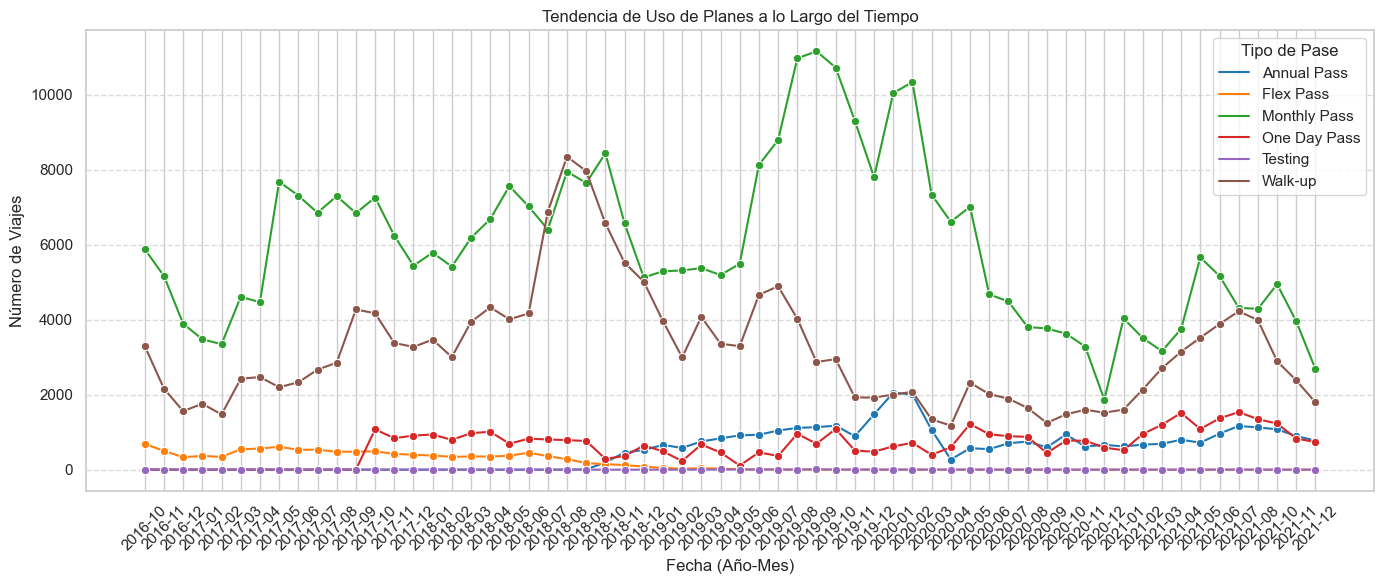

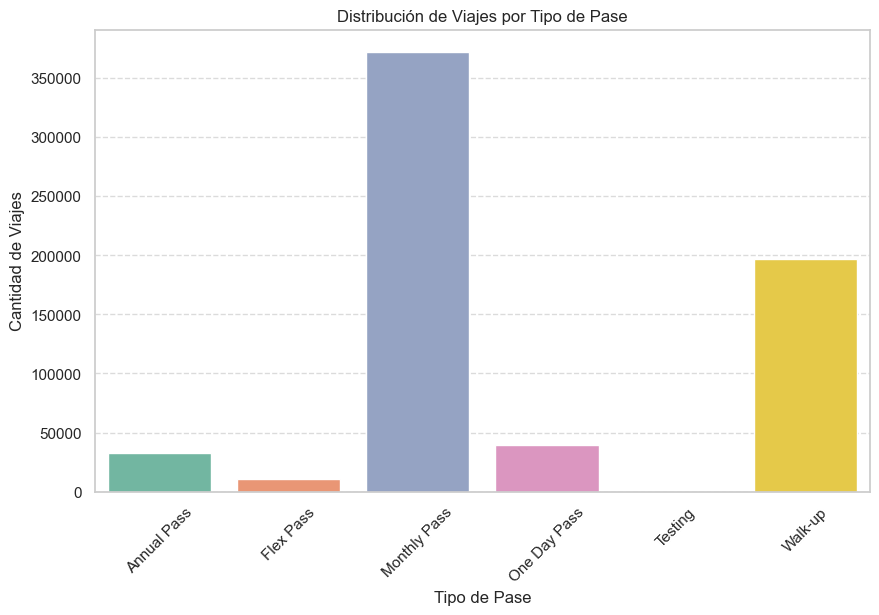

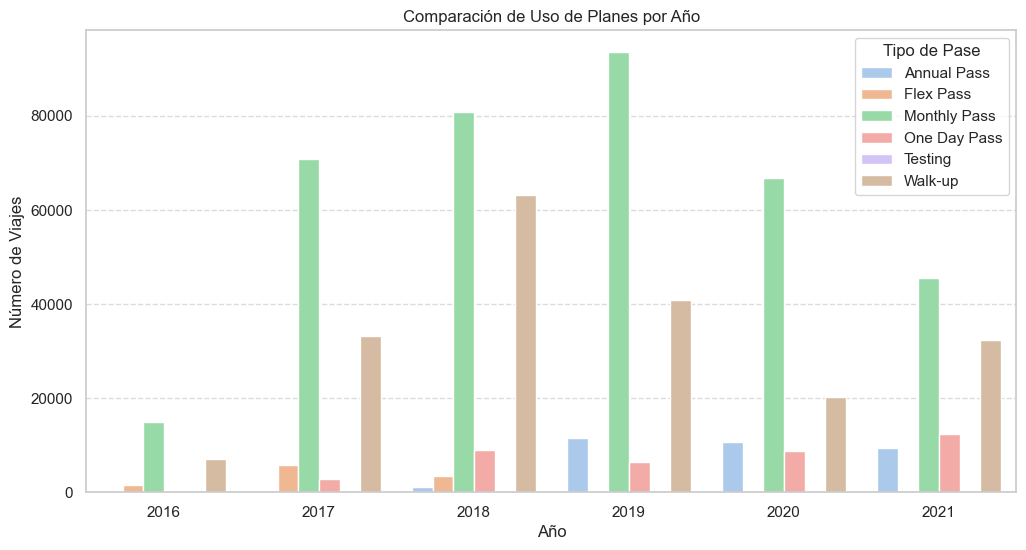

In [27]:
### 📈 2️Análisis de Crecimiento de Planes

def tendencia_planes(df):
    '''Evolución del número de viajes por tipo de pase a lo largo del tiempo.'''
    
    df["year_month"] = df["start_time"].dt.to_period("M").astype(str)
    
    # Agrupar datos por mes y tipo de pase
    plan_trend = df.groupby(["year_month", "passholder_type"]).size().reset_index(name="trip_count")

    plt.figure(figsize=(14, 6))
    sns.lineplot(
        data=plan_trend,
        x="year_month", 
        y="trip_count", 
        hue="passholder_type", 
        marker="o", 
        palette="tab10"
    )

    plt.xticks(rotation=45)
    plt.title("Tendencia de Uso de Planes a lo Largo del Tiempo")
    plt.xlabel("Fecha (Año-Mes)")
    plt.ylabel("Número de Viajes")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Tipo de Pase")
    plt.tight_layout()
    plt.show()

def comparacion_planes(df):
    '''Distribución de usuarios por tipo de pase en un gráfico de barras.'''
    
    plan_counts = df["passholder_type"].value_counts().reset_index()
    plan_counts.columns = ["Tipo de Pase", "Cantidad de Viajes"]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=plan_counts, x="Tipo de Pase", y="Cantidad de Viajes", palette="Set2")
    
    plt.title("Distribución de Viajes por Tipo de Pase")
    plt.xlabel("Tipo de Pase")
    plt.ylabel("Cantidad de Viajes")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def crecimiento_anual(df):
    '''Comparación de la participación de cada tipo de pase en diferentes años.'''

    df["year"] = df["start_time"].dt.year

    # Agrupar datos por año y tipo de pase
    yearly_trend = df.groupby(["year", "passholder_type"]).size().reset_index(name="trip_count")

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=yearly_trend, 
        x="year", 
        y="trip_count", 
        hue="passholder_type", 
        palette="pastel"
    )

    plt.title("Comparación de Uso de Planes por Año")
    plt.xlabel("Año")
    plt.ylabel("Número de Viajes")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Tipo de Pase")
    plt.show()



# Ejecutar las funciones para visualizar el crecimiento de planes
tendencia_planes(df_clean)
comparacion_planes(df_clean)
crecimiento_anual(df_clean)


### **Análisis del Crecimiento de Planes en el Uso de Bicicletas Compartidas**  

1. **Tendencia de uso a lo largo del tiempo:**  
   - El **Monthly Pass** domina con fluctuaciones, pero mantiene alta demanda.  
   - El **Walk-up** es el segundo más usado, lo que indica una base fuerte de usuarios ocasionales.  
   - Caídas en 2020 sugieren impacto de la pandemia; recuperación parcial en 2021.  

2. **Distribución de viajes por tipo de pase:**  
   - El **Monthly Pass** y el **Walk-up** concentran la mayoría de los viajes.  
   - Planes anuales y flexibles tienen menor adopción, lo que indica poco interés en compromisos largos.  

3. **Comparación por año:**  
   - Fuerte crecimiento hasta 2019; caída en 2020 por la pandemia.  
   - Recuperación lenta, pero aún sin alcanzar niveles previos en algunos planes.  

### **Conclusiones**  
- El **Monthly Pass** es clave, pero debe reforzarse para evitar bajas en su demanda.  
- El **Walk-up** indica oportunidad para mejorar la conversión de usuarios ocasionales a suscriptores.  
- Se necesitan estrategias para recuperar la demanda y fomentar planes anuales.

---

## **Conclusión y Hallazgos Clave del Análisis Exploratorio**

El análisis realizado proporciona una visión clara sobre la **saturación del servicio** y el **crecimiento de planes** en el sistema de bicicletas compartidas. A partir de los datos explorados, se identifican los siguientes puntos clave:

### **1. Saturación del Servicio**
- **Patrones de uso horario:** 
  - El uso de bicicletas tiene picos en horarios laborales, especialmente entre **7:00-9:00 AM** y **5:00-7:00 PM**, lo que indica una alta dependencia del servicio para traslados al trabajo y la escuela.
  - Los fines de semana, la demanda es más uniforme, sugiriendo un uso recreativo.
  
- **Estaciones con mayor carga de viajes:** 
  - Existen **puntos críticos de alta demanda** en el centro de Los Ángeles, Santa Mónica y Long Beach.
  - Algunas estaciones tienen un desbalance alto entre salidas y llegadas, lo que indica necesidad de redistribución de bicicletas.

- **Análisis geoespacial:**
  - El mapa de calor muestra **zonas de alta saturación**, lo que sugiere la necesidad de ajustar la disponibilidad de bicicletas en ciertas estaciones.
  - Los clusters identificados con K-Means permiten segmentar áreas de alto uso y optimizar la infraestructura del sistema.

### **2. Crecimiento de Planes**
- **Tendencia en el tiempo:**
  - El uso general del servicio mostró un crecimiento sostenido hasta 2019, seguido de una caída y posterior recuperación.
  - Los planes **Walk-up (ocasionales) y Monthly Pass (mensuales)** son los más usados, lo que refuerza la idea de que el servicio es utilizado principalmente como un medio de transporte diario y no solo recreativo.

- **Comparación anual y por tipo de pase:**
  - Se observa un crecimiento en el uso de **pases anuales**, lo que sugiere que más usuarios están optando por una suscripción de largo plazo.
  - Sin embargo, hay una dependencia alta de los pases esporádicos, lo que puede generar ingresos variables y afectar la planificación operativa.

### **Conclusiones Relevantes para el Modelo Analítico**
- **El tipo de pase parece estar influenciado por múltiples factores**, como la hora del día, el día de la semana, la estación de inicio, la duración del viaje y si el usuario hace un viaje de ida o redondo (*One Way vs. Round Trip*).
- **Patrones en los datos sugieren que es posible inferir el tipo de pase** con un modelo de clasificación, lo que permitiría segmentar a los usuarios y ofrecer incentivos personalizados para fomentar la conversión a planes de suscripción.
- La redistribución de bicicletas basada en **patrones de saturación y desbalance** podría mejorar la disponibilidad del servicio sin necesidad de aumentar drásticamente la infraestructura.

---

Este análisis exploratorio establece la base para el siguiente paso: **el desarrollo del modelo analítico** para predecir el tipo de pase en función de las variables de viaje. Esto permitirá a la empresa tomar decisiones informadas sobre precios, promociones y distribución de bicicletas.

In [33]:
# Convertir bike_id a string para evitar errores con Feather
df_clean["bike_id"] = df_clean["bike_id"].astype(str)

# Guardar en formato Feather
df_clean.to_feather("df_clean.feather")

print("Archivo guardado correctamente como df_clean.feather")

Archivo guardado correctamente como df_clean.feather


## Analisis de test_set.csv


In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# Función para buscar archivos en la jerarquía de carpetas
def find_file(filename, search_dir=None):
    """
    Busca un archivo en la jerarquía de carpetas hacia arriba hasta encontrarlo.
    Si search_dir no se especifica, comienza desde el directorio actual.
    """
    search_dir = Path(search_dir) if search_dir else Path.cwd()
    
    # Buscar en la carpeta actual y en directorios padres
    for directory in [search_dir] + list(search_dir.parents):
        file_path = directory / filename
        if file_path.exists():
            return file_path

    raise FileNotFoundError(f'❌ No se encontró el archivo "{filename}" en la estructura de directorios.')

# Intentar cargar el dataset de test
try:
    test_data_path = find_file('data/test_set.csv')
    df_test = pd.read_csv(test_data_path)
    print(f'Dataset cargado correctamente desde: {test_data_path}')
except FileNotFoundError as e:
    print(e)
    df_test = None  # Evita errores si el dataset no se encuentra

# Función para normalizar el formato de fechas sin perder datos
def normalize_date_format(date_str, most_common_date):
    """
    Convierte fechas a un formato estándar 'YYYY-MM-DD HH:MM:SS'.
    Si el formato no es reconocido, usa la fecha más común en el dataset.
    """
    if pd.isna(date_str):  # Si es NaN, devolver la fecha más común
        return most_common_date

    # Si ya está en formato ISO 8601 (YYYY-MM-DD HH:MM:SS), lo dejamos igual
    if re.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', date_str):
        return date_str

    # Si el formato es M/D/YYYY H:MM (sin segundos), convertirlo
    if re.match(r'\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}', date_str):
        return pd.to_datetime(date_str, format='%m/%d/%Y %H:%M').strftime('%Y-%m-%d %H:%M:%S')

    # Si el formato es M/D/YYYY (sin hora), agregar hora por defecto
    if re.match(r'\d{1,2}/\d{1,2}/\d{4}', date_str):
        return pd.to_datetime(date_str, format='%m/%d/%Y').strftime('%Y-%m-%d 00:00:00')

    return most_common_date  # Si el formato no es válido, usa la fecha más común


# Aplicar normalización a las fechas
if df_test is not None:
    print("\n📌 Normalizando fechas...")

    # Determinar la fecha más común del dataset
    most_common_start = df_test['start_time'].mode()[0] if not df_test['start_time'].isna().all() else "2016-01-01 00:00:00"
    most_common_end = df_test['end_time'].mode()[0] if not df_test['end_time'].isna().all() else "2016-01-01 00:00:00"

    df_test['start_time'] = df_test['start_time'].astype(str).apply(lambda x: normalize_date_format(x, most_common_start))
    df_test['end_time'] = df_test['end_time'].astype(str).apply(lambda x: normalize_date_format(x, most_common_end))

    # Convertir fechas a tipo datetime y reemplazar NaT con la moda
    df_test['start_time'] = pd.to_datetime(df_test['start_time'], errors='coerce')
    df_test['end_time'] = pd.to_datetime(df_test['end_time'], errors='coerce')

    # Reemplazar NaT con la moda
    df_test['start_time'].fillna(most_common_start, inplace=True)
    df_test['end_time'].fillna(most_common_end, inplace=True)

    print(" Fechas normalizadas sin pérdida de datos.")








C:\Users\candy\AppData\Local\Temp\ipykernel_40984\2730742208.py:25: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(test_data_path)


Dataset cargado correctamente desde: c:\Users\candy\Downloads\arkon_ds\data\test_set.csv

📌 Normalizando fechas...
 Fechas normalizadas sin pérdida de datos.


C:\Users\candy\AppData\Local\Temp\ipykernel_40984\2730742208.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['start_time'].fillna(most_common_start, inplace=True)
C:\Users\candy\AppData\Local\Temp\ipykernel_40984\2730742208.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [5]:
# Función para mostrar información general del dataset de test
def summarize_test_data(df):
    """Muestra un resumen general del DataFrame de test."""
    if df is None or df.empty:
        print(" El DataFrame de test está vacío o no se cargó correctamente.")
        return

    print("\n Primeras filas del dataset de test:")
    display(df.head())

    print("\n Información general del dataset:")
    df.info()

    print("\n Estadísticas descriptivas:")
    display(df.describe(include='all'))

    print("\n Columnas del dataset de test:")
    print(df.columns.to_list())


    # Rellenar valores nulos en latitudes y longitudes con valores cercanos
    print("\n Valores nulos por columna:")
    df[['start_lat', 'start_lon', 'end_lat', 'end_lon']] = df[['start_lat', 'start_lon', 'end_lat', 'end_lon']].fillna(df[['start_lat', 'start_lon', 'end_lat', 'end_lon']].mean())

    

   

# Ejecutar funciones de análisis en el dataset de test limpio
if df_test is not None:
    summarize_test_data(df_test)




 Primeras filas del dataset de test:


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
0,17059130,12,2017-01-01 00:24:00,2017-01-01 00:36:00,34.058319,-118.246094,34.058319,-118.246094,6351,Round Trip,3028,3028
1,17059129,17,2017-01-01 00:28:00,2017-01-01 00:45:00,34.049980,-118.247162,34.043732,-118.260139,5836,One Way,3027,3018
2,17059126,20,2017-01-01 00:39:00,2017-01-01 00:59:00,34.063389,-118.236160,34.044159,-118.251579,6529,One Way,3066,3055
3,17059125,12,2017-01-01 00:43:00,2017-01-01 00:55:00,34.048851,-118.246422,34.050140,-118.233238,6029,One Way,3029,3079
4,17061379,48,2017-01-01 00:56:00,2017-01-01 01:44:00,34.049198,-118.252831,34.049198,-118.252831,6680,Round Trip,3063,3063



 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569886 entries, 0 to 569885
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_id              569886 non-null  int64         
 1   duration             569886 non-null  int64         
 2   start_time           569886 non-null  datetime64[ns]
 3   end_time             569886 non-null  datetime64[ns]
 4   start_lat            569886 non-null  float64       
 5   start_lon            569886 non-null  float64       
 6   end_lat              569886 non-null  float64       
 7   end_lon              569886 non-null  float64       
 8   bike_id              569886 non-null  object        
 9   trip_route_category  569886 non-null  object        
 10  start_station        569886 non-null  int64         
 11  end_station          569886 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
count,5.698860e+05,569886.000000,569886,569886,569886.000000,569886.000000,569886.000000,569886.000000,569886,569886,569886.000000,569886.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6893,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16600,One Way,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,836,473657,NaN,NaN
mean,1.069478e+08,36.946784,2019-04-09 07:42:12.284742656,2019-04-09 08:26:24.070141696,34.045948,-118.248260,34.046501,-118.243570,NaN,NaN,3500.436019,3490.855975
min,8.369649e+06,1.000000,2016-10-01 00:38:00,2016-10-01 00:54:00,33.710979,-118.495422,33.710979,-118.495422,NaN,NaN,3000.000000,3000.000000
25%,7.533220e+07,7.000000,2018-03-05 12:09:15,2018-03-05 12:51:45,34.037460,-118.280952,34.038609,-118.279762,NaN,NaN,3031.000000,3030.000000
50%,1.178757e+08,13.000000,2019-03-21 18:26:30,2019-03-21 18:48:00,34.046612,-118.256668,34.046520,-118.256668,NaN,NaN,3064.000000,3064.000000
75%,1.403708e+08,26.000000,2020-04-02 20:42:45,2020-04-02 21:04:45,34.051941,-118.247162,34.050911,-118.243570,NaN,NaN,4214.000000,4214.000000
max,1.794925e+08,1440.000000,2021-12-31 23:48:00,2022-01-02 12:56:00,55.705528,37.606541,55.705528,37.606541,NaN,NaN,4594.000000,4594.000000



 Columnas del dataset de test:
['trip_id', 'duration', 'start_time', 'end_time', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'bike_id', 'trip_route_category', 'start_station', 'end_station']

 Valores nulos por columna:


In [6]:
# Guardar el dataset limpio en formato Feather
feather_path = Path("../data/test_set_clean.feather")

try:
    df_test["bike_id"] = df_test["bike_id"].astype(str)  # Convertir bike_id a string para evitar errores
    df_test.to_feather(feather_path)
    print(f" Dataset de test limpio guardado correctamente como: {feather_path}")
except Exception as e:
    print(f" Error al guardar el dataset limpio: {e}")

 Dataset de test limpio guardado correctamente como: ..\data\test_set_clean.feather
